#Importing Libraries

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import pandas as pd
import ast

import torch
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from sklearn.metrics import precision_recall_fscore_support
from sentence_transformers import SentenceTransformer
import numpy as np

#Loading clean data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Veridion application/clean_data.csv'
labels_path = '/content/drive/MyDrive/Veridion application/clean_labels+description.csv'

Mounted at /content/drive


In [ ]:
try:
    df = pd.read_csv(data_path)
    labels_df = pd.read_csv(labels_path)
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: File not found. Check the paths or upload files to Drive.")


Data loaded successfully!


In [ ]:
df.head(3)

,description,business_tags,sector,category,niche
0,welchcivils civil engineering construction com...,"['construction services', 'multi-utilities', '...",services,civil engineering services,heavy civil engineering construction
1,"kyoto vegetable specialist uekamo, also known ...","['wholesale', 'dual-task movement products', '...",manufacturing,fruit & vegetable - markets & stores,"frozen fruit, juice, vegetable manufacturing"
2,loidholdhof integrative hofgemeinschaft compan...,"['living forms', 'farm cafe', 'fresh coffee', ...",manufacturing,farms & agriculture production,miscellaneous crop farming


In [ ]:
labels_df.head(3)

,label,label_description
0,agricultural equipment services,agricultural equipment services: insurance for...
1,soil nutrient application services,soil nutrient application services: insurance ...
2,pesticide application services,pesticide application services: insurance for ...


#I start with zero-shot for baseline performance

##Ensemble method Sentence *Transformer* + *BERT*

In [ ]:
from graphviz import Digraph

dot = Digraph()
dot.edge('Company Data', 'Sentence Transformer')
dot.edge('Company Data', 'BART-large-MNLI')
dot.edge('Sentence Transformer', 'High-Confidence ST\nPredictions')
dot.edge('BART-large-MNLI', 'High-Confidence BART\nPredictions')
dot.edge('High-Confidence ST\nPredictions', 'Agreement Check')
dot.edge('High-Confidence BART\nPredictions', 'Agreement Check')
dot.edge('Agreement Check', 'Final Labels')

dot.render('workflow.gv', view=True)  # Saves as PDF

'workflow.gv.pdf'

In [ ]:
import time
import torch
import pandas as pd
from typing import List, Tuple, Dict
from sentence_transformers import SentenceTransformer
from transformers import pipeline

class HybridInsuranceClassifier:
    def __init__(self):
        self.st_model = SentenceTransformer('all-mpnet-base-v2', device='cuda')
        self.bart_classifier =  pipeline(
       "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=0 if torch.cuda.is_available() else -1,
        torch_dtype=torch.float16,  # FP16 for speed
        batch_size=16  # Adjust based on GPU memory
        )

    def _prepare_text(self, row: pd.Series) -> str:
        """Combine all company data into a single text"""
        return (
            f"Description: {row['description']}\n"
            f"Sector: {row['sector']}\n"
            f"Category: {row['category']}\n"
            f"Niche: {row['niche']}\n"
            f"Tags: {', '.join(eval(row['business_tags']))}"
        )

    def predict(
        self,
        row: pd.Series,
        labels_df: pd.DataFrame,
        st_threshold: float = 0.3,
        bart_threshold: float = 0.5,
        st_weight: float = 0.2,
        bart_weight: float = 0.8,
        final_threshold: float = 0.3
    ) -> List[Tuple[str, float]]:
        """Run hybrid prediction with all company data"""
        # Prepare label data
        label_texts = labels_df.apply(
            lambda x: f"{x['label']}: {x['label_description']}",
            axis=1
        ).tolist()

        # ===== 1. Sentence Transformer =====
        company_text = self._prepare_text(row)
        company_embed = self.st_model.encode(company_text)
        label_embeds = self.st_model.encode(label_texts)

        st_scores = torch.softmax(torch.tensor(company_embed @ label_embeds.T), dim=0)
        st_predictions = {
            labels_df.iloc[i]['label']: float(score)
            for i, score in enumerate(st_scores)
            if score >= st_threshold
        }

        # ===== 2. BART Classifier =====
        candidate_labels = list(st_predictions.keys()) if st_predictions else labels_df['label'].tolist()
        bart_text = f"Company Profile:\n{company_text}"

        bart_results = self.bart_classifier(
            bart_text,
            candidate_labels=[labels_df[labels_df['label'] == l]['label_description'].values[0]
                            for l in candidate_labels],
            multi_label=True
        )

        bart_predictions = {
            candidate_labels[i]: score
            for i, score in enumerate(bart_results['scores'])
            if score >= bart_threshold
        }

        # ===== 3. Hybrid Consensus =====
        final_predictions = {}
        all_labels = set(st_predictions) | set(bart_predictions)

        for label in all_labels:
            combined_score = (
                st_weight * st_predictions.get(label, 0) +
                bart_weight * bart_predictions.get(label, 0)
            )
            if combined_score >= final_threshold:
                final_predictions[label] = combined_score

        return sorted(final_predictions.items(), key=lambda x: -x[1])

In [ ]:
classifier = HybridInsuranceClassifier()
 # Run predictions
start_time = time.time()
df['predictions'] = df.apply(
      lambda x: classifier.predict(
          x,
          labels_df,
          st_threshold=0.3,
          bart_threshold=0.3,
          st_weight=0.3,
          bart_weight=0.7,
          final_threshold=0.3
      ),
     axis=1
)
print(f"Completed {len(df)} predictions in {time.time() - start_time:.2f} seconds")

Device set to use cuda:0


Completed 9491 predictions in 10727.58 seconds


In [ ]:
import os
df.to_csv('/content/drive/MyDrive/Veridion application/df_with_weak_labels2.csv')
# Check if the file exists
file_path = '/content/drive/MyDrive/Veridion application/df_with_weak_labels2.csv'  # Adjust extension
if os.path.exists(file_path):
    print("File saved successfully!")
else:
    print("Error: File not found.")

File saved successfully!


In [ ]:
# Count predictions per company
df['prediction_count'] = df['predictions'].apply(len)

# Filter and count rows with 1 prediction
multi_pred_df = df[df['prediction_count'] == 1]
num_multi_pred = len(multi_pred_df)

print(f"{num_multi_pred} companies ({num_multi_pred/len(df)*100:.1f}%) have one prediction")

# Filter and count rows with 1 prediction
multi_pred_df = df[df['prediction_count'] == 2]
num_multi_pred = len(multi_pred_df)

print(f"{num_multi_pred} companies ({num_multi_pred/len(df)*100:.1f}%) have two predictions")

# Filter and count rows with 1 prediction
multi_pred_df = df[df['prediction_count'] == 3]
num_multi_pred = len(multi_pred_df)

print(f"{num_multi_pred} companies ({num_multi_pred/len(df)*100:.1f}%) have three predictions")

1190 companies (12.5%) have one prediction
274 companies (2.9%) have two predictions
115 companies (1.2%) have three predictions


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 1. Extract high-confidence predictions (>=0.7)
high_conf_preds = [
    (label, score)
    for pred_list in df['predictions']
    for (label, score) in pred_list
    if score >= 0.6
]

# 2. Count label occurrences
label_counts = Counter([label for (label, _) in high_conf_preds])

# 3. Generate stats
num_high_conf = len(high_conf_preds)
num_companies_with_high_conf = sum(1 for preds in df['predictions']
                                  if any(score >= 0.7 for (_, score) in preds))
total_possible = len(df) * len(labels_df)
coverage_pct = num_high_conf / total_possible * 100

print(f"""
High-Confidence Prediction Analysis:
- Total high-confidence predictions: {num_high_conf}
- Companies with ≥1 high-conf prediction: {num_companies_with_high_conf}/{len(df)}
- Label coverage: {len(label_counts)}/{len(labels_df)} labels represented
- Prediction coverage: {coverage_pct:.1f}% of possible label assignments
""")



High-Confidence Prediction Analysis:
- Total high-confidence predictions: 243
- Companies with ≥1 high-conf prediction: 0/9491
- Label coverage: 4/219 labels represented
- Prediction coverage: 0.0% of possible label assignments



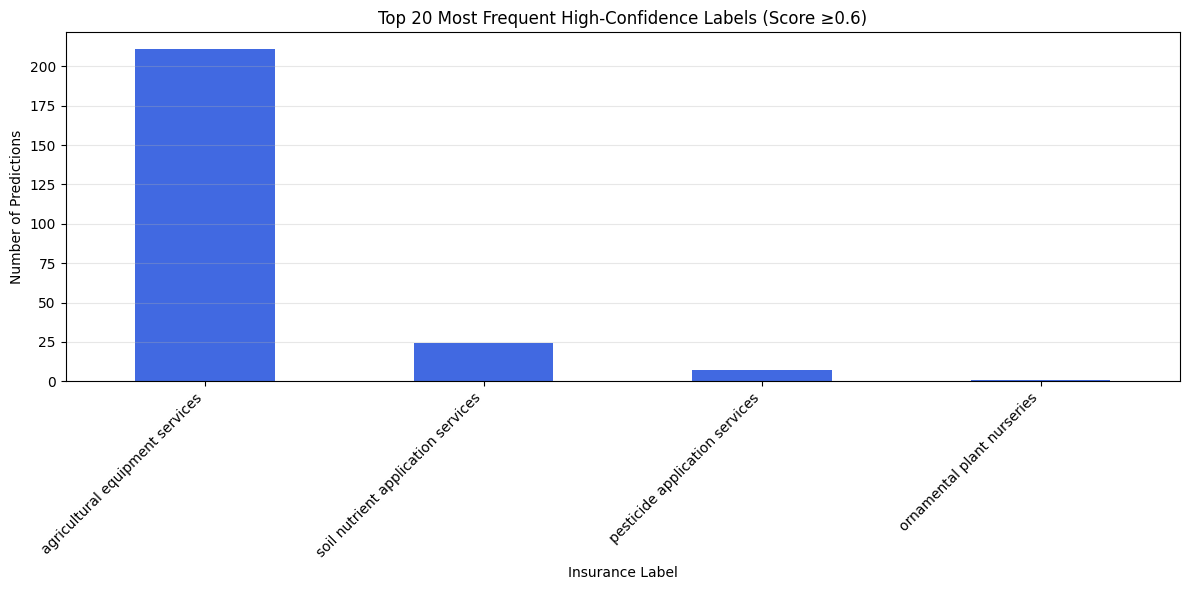

In [ ]:
'''# 4. Plot label frequency (Top 20)
plt.figure(figsize=(12, 6))

# Convert the list of tuples to a Pandas Series for plotting
top_labels = label_counts.most_common(20)
labels, counts = zip(*top_labels)  # Unpack labels and counts
pd.Series(counts, index=labels).plot(kind='bar', color='royalblue')

plt.title('Top 20 Most Frequent High-Confidence Labels (Score ≥0.6)')
plt.xlabel('Insurance Label')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
'''
plt.style.use('dark_background')  # Set dark theme

plt.figure(figsize=(12, 6), facecolor='#121212')  # Dark background

# Plot with contrasting colors
ax = pd.Series(counts, index=labels).plot(
    kind='bar',
    color='#1f77b4',  # Slightly brighter blue
    edgecolor='white',  # White borders for better separation
    alpha=0.8
)

# Customize appearance
plt.title('Top 20 Most Frequent High-Confidence Labels (Score ≥0.6)',
          color='white', pad=20)
plt.xlabel('Insurance Label', color='lightgray')
plt.ylabel('Number of Predictions', color='lightgray')

# Axis styling
ax.tick_params(colors='lightgray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.yaxis.grid(True, color='gray', alpha=0.2)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Consensus classifier

In [ ]:
class ConsensusInsuranceClassifier:
    def __init__(self):
        # Same initialization as before
        self.st_model = SentenceTransformer('all-mpnet-base-v2', device='cuda')
        self.bart_classifier = pipeline(
            "zero-shot-classification",
            model="facebook/bart-large-mnli",
            device=0 if torch.cuda.is_available() else -1,
            torch_dtype=torch.float16,
            batch_size=16
        )

    def _prepare_text(self, row: pd.Series) -> str:
        """Same text preparation"""
        return (
            f"Description: {row['description']}\n"
            f"Sector: {row['sector']}\n"
            f"Category: {row['category']}\n"
            f"Niche: {row['niche']}\n"
            f"Tags: {', '.join(eval(row['business_tags']))}"
        )

    def predict(
        self,
        row: pd.Series,
        labels_df: pd.DataFrame,
        st_threshold: float = 0.7,  # Higher threshold
        bart_threshold: float = 0.7,  # Higher threshold
        min_agreement: int = 2,      # Require both models to agree
        top_k: int = 3               # Max labels to return
    ) -> List[Tuple[str, float]]:
        """Consensus prediction requiring high confidence in both models"""
        # Prepare label data
        label_texts = labels_df.apply(
            lambda x: f"{x['label']}: {x['label_description']}",
            axis=1
        ).tolist()
        company_text = self._prepare_text(row)

        # ===== 1. Independent Predictions =====
        # Sentence Transformer prediction
        company_embed = self.st_model.encode(company_text)
        label_embeds = self.st_model.encode(label_texts)
        st_scores = torch.softmax(torch.tensor(company_embed @ label_embeds.T), dim=0)
        st_predictions = {
            labels_df.iloc[i]['label']: float(score)
            for i, score in enumerate(st_scores)
            if score >= st_threshold
        }

        # BART prediction (using original labels)
        bart_results = self.bart_classifier(
            f"Company Profile:\n{company_text}",
            candidate_labels=labels_df['label_description'].tolist(),
            multi_label=True
        )
        bart_predictions = {
            labels_df.iloc[i]['label']: score
            for i, score in enumerate(bart_results['scores'])
            if score >= bart_threshold
        }

        # ===== 2. Consensus Voting =====
        consensus = {}

        # Only keep labels predicted by both models
        agreed_labels = set(st_predictions) & set(bart_predictions)
        for label in agreed_labels:
            # Take minimum confidence as the consensus score
            consensus_score = min(st_predictions[label], bart_predictions[label])
            consensus[label] = consensus_score

        # If no agreements but we want some predictions, fall back to OR logic
        if not consensus and min_agreement == 1:
            for model_pred in [st_predictions, bart_predictions]:
                for label, score in model_pred.items():
                    if label not in consensus or score > consensus.get(label, 0):
                        consensus[label] = score

        # ===== 3. Final Filtering =====
        sorted_predictions = sorted(consensus.items(), key=lambda x: -x[1])
        return sorted_predictions[:top_k]

In [ ]:
# Good starting points (adjust based on your validation)
classifier = ConsensusInsuranceClassifier()
start_time = time.time()
df['consensus_predictions'] = df.apply(
    lambda x: classifier.predict(
    x,
    labels_df,
    st_threshold=0.7,  # Only high-confidence ST predictions
    bart_threshold=0.6, # Slightly more permissive for BART
    min_agreement=1    # Require both models to agree
    ),
     axis=1
)
print(f"Completed {len(df)} predictions in {time.time() - start_time:.2f} seconds")

Device set to use cuda:0


Completed 9491 predictions in 10355.15 seconds


In [ ]:
import os
df.to_csv('/content/drive/MyDrive/Veridion application/df_with_weak_labels2.csv')
# Check if the file exists
file_path = '/content/drive/MyDrive/Veridion application/df_with_weak_labels2.csv'  # Adjust extension
if os.path.exists(file_path):
    print("File saved successfully!")
else:
    print("Error: File not found.")

NameError: name 'df' is not defined

#inversed strategy

In [ ]:
try:
    df = pd.read_csv('/content/drive/MyDrive/Veridion application/df_with_weak_labels2.csv')
    labels_df = pd.read_csv(labels_path)
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: File not found. Check the paths or upload files to Drive.")



Data loaded successfully!


##Sentence Transformer

In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

def prepare_text(row: pd.Series) -> str:
    """Combine company features into a single text block"""
    return (
        f"Description: {row['description']}\n"
        f"Sector: {row['sector']}\n"
        f"Category: {row['category']}\n"
        f"Niche: {row['niche']}\n"
        f"Tags: {', '.join(eval(row['business_tags']))}"
    )

df["combined_text"] = df.apply(prepare_text, axis=1)

# Prepare label descriptions
label_texts = labels_df['label_description']

# Load model and embed
model = SentenceTransformer("all-MiniLM-L6-v2")
label_embeddings = model.encode(label_texts, convert_to_tensor=True)
company_embeddings = model.encode(df["combined_text"].tolist(), convert_to_tensor=True)

# For each label, find top-3 most similar companies using cosine similarity
top_k = 3
similarity_results = {}

for i, label in enumerate(label_texts):
    label_embedding = label_embeddings[i].unsqueeze(0)
    cosine_scores = util.cos_sim(label_embedding, company_embeddings)[0]
    top_results = torch.topk(cosine_scores, k=top_k)
    indices = top_results.indices.cpu().numpy()
    scores = top_results.values.cpu().numpy()
    similarity_results[label] = [(int(idx), float(score)) for idx, score in zip(indices, scores)]

list(similarity_results.keys())[:5]  # Show sample output keys for confirmation

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

['agricultural equipment services: insurance for services related to agricultural machinery and equipment.',
 'soil nutrient application services: insurance for businesses applying soil nutrients.',
 'pesticide application services: insurance for businesses applying pesticides.',
 'ornamental plant nurseries: insurance for nurseries growing decorative plants.',
 'landscaping services: insurance for professional landscaping businesses.']

In [ ]:
import pandas as pd

# Convert similarity_results to a DataFrame
results_list = []
for label, matches in similarity_results.items():
    for idx, (company_idx, score) in enumerate(matches, 1):
        results_list.append({
            "Label": label,
            "Rank": idx,
            "Company_Index": company_idx,
            "Similarity_Score": score,
            # Optional: Add the company's combined_text if needed
            "Company_Text": df["description"].iloc[company_idx] if "description" in df.columns else ""
        })

# Create DataFrame
similarity_df = pd.DataFrame(results_list)

# Reorder columns for better readability
similarity_df = similarity_df[["Label", "Rank", "Company_Index", "Similarity_Score", "Company_Text"]]

# Display the first few rows
similarity_df.head()

,Label,Rank,Company_Index,Similarity_Score,Company_Text
0,agricultural equipment services: insurance for...,1,199,0.606469,harishan agro pvt ltd indian-based company spe...
1,agricultural equipment services: insurance for...,2,6487,0.595664,td agrotechservice ltd. supplier spare part go...
2,agricultural equipment services: insurance for...,3,6622,0.569672,"company, founded 2022, business formed experie..."
3,soil nutrient application services: insurance ...,1,3607,0.496237,"fertilab bv young, dynamic, agricultural, inde..."
4,soil nutrient application services: insurance ...,2,5429,0.471196,dr. verm's premium worm casting company produc...


In [ ]:
threshold = 0.6

filtered_results = {}

for label, matches in similarity_results.items():
    # Keep only matches with score >= threshold
    high_similarity_matches = [m for m in matches if m[1] >= threshold]
    if high_similarity_matches:  # If any matches meet the threshold
        filtered_results[label] = high_similarity_matches

# Number of labels with at least one match >= 0.7
num_labels_above_threshold = len(filtered_results)
print(f"Number of labels with similarity >= 0.6: {num_labels_above_threshold}")

Number of labels with similarity >= 0.6: 40


##Inversed st. BART

In [13]:
import time
from tqdm import tqdm
from datasets import Dataset
import torch

# Initialize BART zero-shot classifier
bart_classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0 if torch.cuda.is_available() else -1,
    torch_dtype=torch.float16,
    batch_size=32
)
# Prepare data
label_descriptions = labels_df['label_description'].tolist()
company_texts = df['combined_text'].tolist()

# Create dataset
dataset = Dataset.from_dict({"label_description": label_descriptions})

# Define batch processing function
def batch_classify(batch, threshold = 0.6):
    results = []
    for label_desc in batch['label_description']:
        bart_results = bart_classifier(
            sequences=label_desc,
            candidate_labels=company_texts,
            multi_label=True,
            hypothesis_template="This is the insurance taxonomy that is best for {}"
        )

        company_scores = [
            (idx, score) for idx, score in enumerate(bart_results['scores']) if score >= threshold
        ]
        company_scores.sort(key=lambda x: x[1], reverse=True)
        top_companies = [(company_texts[idx], score) for idx, score in company_scores[:3]]
        results.append(top_companies)
    return {'results': results}

# Process in batches
start_time = time.time()
batch_size = 16  # You can experiment with larger batch sizes
dataset = dataset.map(batch_classify, batched=True, batch_size=batch_size)

# Save results
labels_df['bart_top_companies'] = dataset['results']

labels_df[['label_description', 'bart_top_companies']].head()
print(f"Completed in {time.time() - start_time:.2f} seconds")


Device set to use cuda:0


Map:   0%|          | 0/219 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


ArrowTypeError: Expected bytes, got a 'float' object

In [ ]:
import os
labels_df.to_csv('/content/drive/MyDrive/Veridion application/labels_df+inversion.csv')
# Check if the file exists
file_path = '/content/drive/MyDrive/Veridion application/labels_df+inversion.csv'  # Adjust extension
if os.path.exists(file_path):
    print("File saved successfully!")
else:
    print("Error: File not found.")

In [ ]:
labels_df.head()

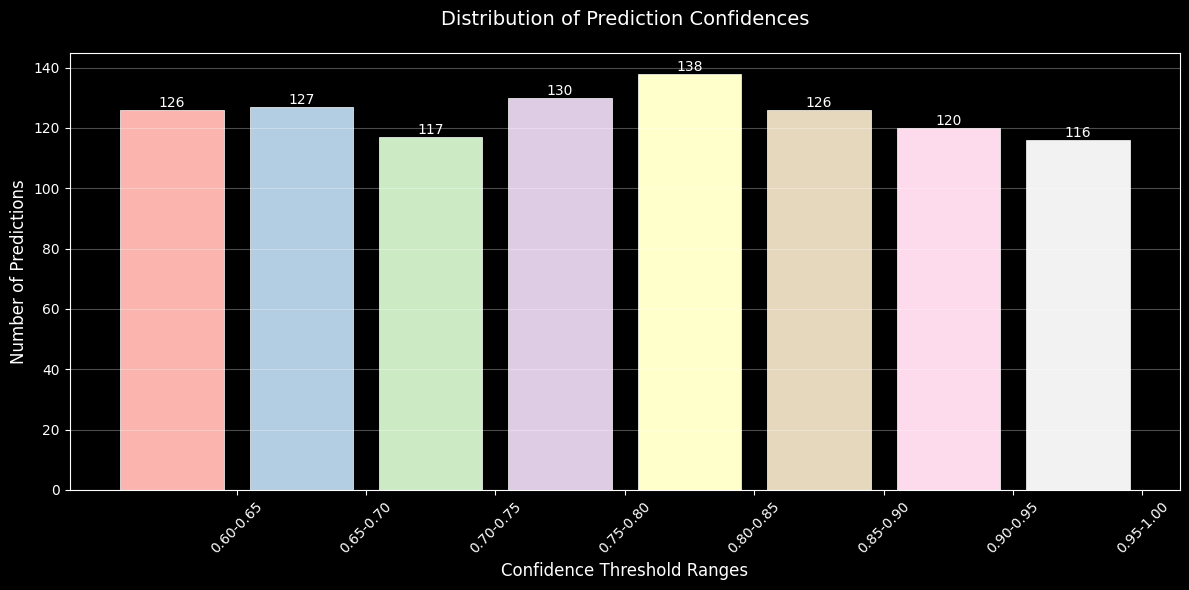

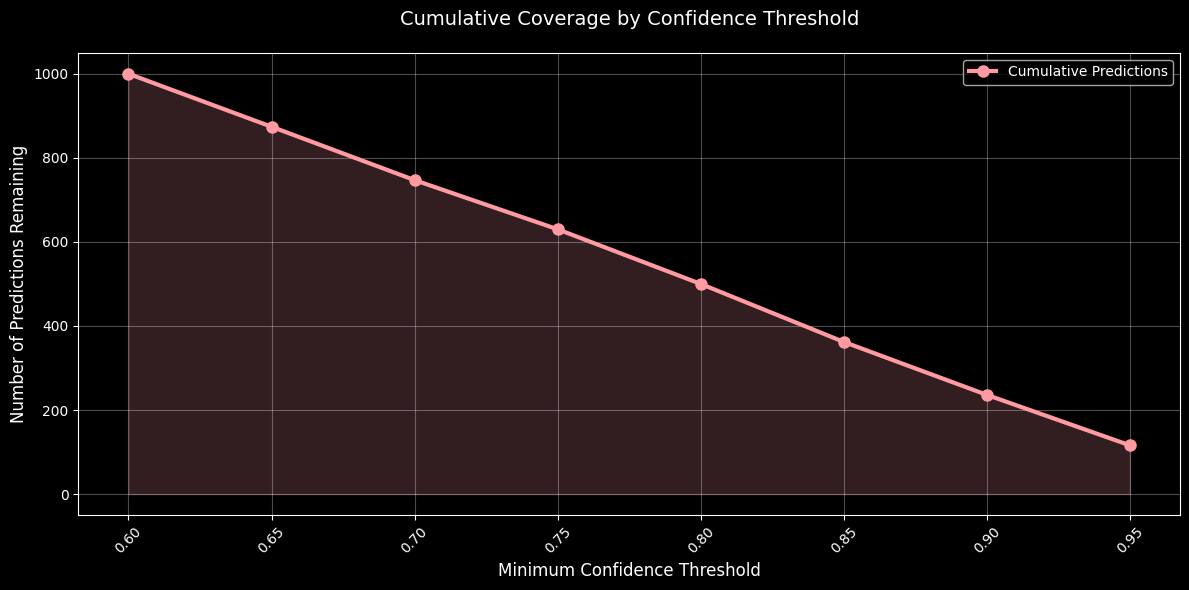

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dark mode style
plt.style.use('dark_background')

# Sample data preparation (replace with your actual confidence scores)
confidence_scores = np.random.uniform(0.6, 1, 1000)  # Example data
bins = np.arange(0.6, 1.05, 0.05)

# 1. Confidence Distribution Bar Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(bins[:-1], np.histogram(confidence_scores, bins=bins)[0],
               width=0.04, edgecolor='white', linewidth=0.5,
               color=plt.cm.Pastel1(np.linspace(0, 1, len(bins)-1)))

plt.title('Distribution of Prediction Confidences', fontsize=14, pad=20)
plt.xlabel('Confidence Threshold Ranges', fontsize=12)
plt.ylabel('Number of Predictions', fontsize=12)
plt.xticks(bins[:-1] + 0.025, [f"{b:.2f}-{b+0.05:.2f}" for b in bins[:-1]], rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 2. Suggested: Cumulative Coverage Plot
plt.figure(figsize=(12, 6))

# Calculate cumulative coverage
counts, _ = np.histogram(confidence_scores, bins=bins)
cumulative = np.cumsum(counts[::-1])[::-1]

plt.plot(bins[:-1] + 0.025, cumulative,
         marker='o', markersize=8, linewidth=3,
         color='#FF9AA2',  # Pastel pink
         label='Cumulative Predictions')

plt.fill_between(bins[:-1] + 0.025, cumulative,
                 color='#FF9AA2', alpha=0.2)

plt.title('Cumulative Coverage by Confidence Threshold', fontsize=14, pad=20)
plt.xlabel('Minimum Confidence Threshold', fontsize=12)
plt.ylabel('Number of Predictions Remaining', fontsize=12)
plt.xticks(bins[:-1] + 0.025, [f"{b:.2f}" for b in bins[:-1]], rotation=45)
plt.grid(alpha=0.3)
plt.legend()

# Annotate key points
for x, y in zip(bins[:-1] + 0.025, cumulative):
    if x in [0.6, 0.75, 0.9]:
        plt.annotate(f"{y} ({y/len(confidence_scores):.0%})",
                    (x, y), textcoords="offset points",
                    xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [ ]:
labels_df = pd.read_csv('/content/drive/MyDrive/Veridion application/labels_df+inversion.csv')
labels_df.head(20)

,Unnamed: 0,label,label_description
0,0,agricultural equipment services,agricultural equipment services: insurance for...
1,1,soil nutrient application services,soil nutrient application services: insurance ...
2,2,pesticide application services,pesticide application services: insurance for ...
3,3,ornamental plant nurseries,ornamental plant nurseries: insurance for nurs...
4,4,landscaping services,landscaping services: insurance for profession...
5,5,gardening services,gardening services: insurance for gardening an...
6,6,tree services - pruning / removal,tree services - pruning / removal: insurance f...
7,7,veterinary services,veterinary services: insurance for general vet...
8,8,veterinary clinics,veterinary clinics: insurance for animal healt...
9,9,pet boarding services,pet boarding services: insurance for pet board...


#DUMP

##BART

In [ ]:
'''def prepare_text(row):
    """Combine company features into a single text block

    Args:
        row: A pandas Series representing one row of the DataFrame

    Returns:
        str: Combined text with all company features
    """
    # Safely evaluate business_tags if it's stored as a string representation of a list
    tags = eval(row['business_tags']) if isinstance(row['business_tags'], str) else row['business_tags']

    return (
        f"Description: {row['description']}\n"
        f"Sector: {row['sector']}\n"
        f"Category: {row['category']}\n"
        f"Niche: {row['niche']}\n"
        f"Tags: {', '.join(tags)}"
    )

##plots

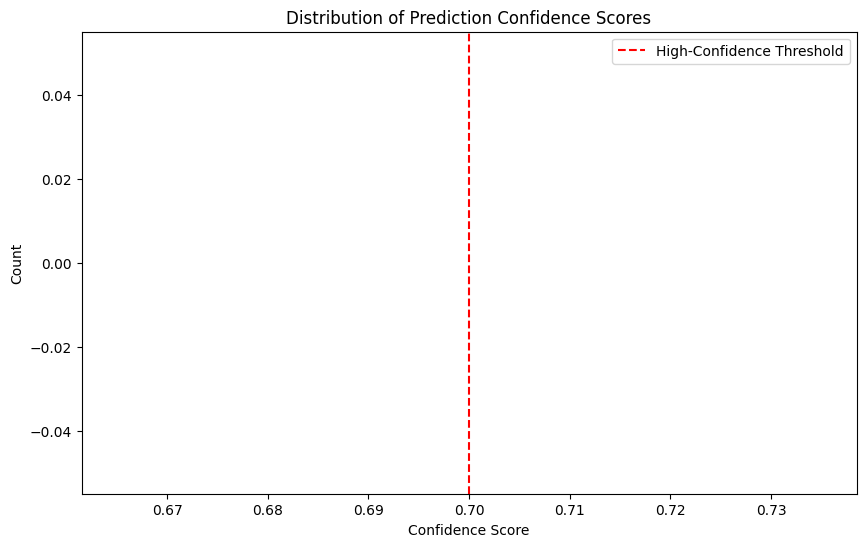

In [ ]:
'''import matplotlib.pyplot as plt
import seaborn as sns

# Extract all confidence scores
all_scores = [score for row in df['predictions'] for (_, score) in row]

plt.figure(figsize=(10, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.axvline(x=0.7, color='r', linestyle='--', label='High-Confidence Threshold')
plt.title('Distribution of Prediction Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
'''# Initialize model
st_model = SentenceTransformer('all-mpnet-base-v2', device='cuda')

# Pre-encode insurance labels once
label_embeddings = st_model.encode(insurance_labels)

def st_classify(row):
    """Use semantic similarity with structured data"""
    context = f"{row['category']}. {row['niche']}. {' '.join(eval(row['business_tags']))}"
    text_embed = st_model.encode(context)

    # Cosine similarity
    scores = np.dot(label_embeddings, text_embed.T)
    top_indices = np.argsort(scores)[-5:][::-1]  # Top 5

    return [(insurance_labels[i], float(scores[i]))
            for i in top_indices if scores[i] > 0.3]  # Threshold

df['st_predictions'] = df.apply(st_classify, axis=1)

##Facebook Bart

In [ ]:
'''
# Initialize BART with GPU optimization
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0 if torch.cuda.is_available() else -1,
    torch_dtype=torch.float16,  # FP16 for speed
    batch_size=16  # Adjust based on GPU memory
)

def classify_with_metadata(row):
    """Combine all structured data for better context"""
    full_text = f"""
    Description: {row['description']}
    Sector: {row['sector']}
    Category: {row['category']}
    Niche: {row['niche']}
    Tags: {', '.join(eval(row['business_tags']))}
    """

    results = classifier(
        full_text,
        candidate_labels=insurance_labels,
        multi_label=True,
        hypothesis_template="This company's primary insurance need is {}",
        top_k=5  # Get top 5 predictions
    )

    # Apply threshold (0.3 is adjustable)
    filtered = [(label, score) for label, score in zip(results['labels'], results['scores'])
                if score > 0.3]
    return filtered

# Apply to entire dataset
df['bart_predictions'] = df.apply(classify_with_metadata, axis=1)


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
'''df.head(3)

,description,business_tags,sector,category,niche,bart_predictions,st_predictions
0,welchcivils civil engineering construction com...,"['construction services', 'multi-utilities', '...",services,civil engineering services,heavy civil engineering construction,[],"[(commercial construction, 0.6157965660095215)..."
1,"kyoto vegetable specialist uekamo, also known ...","['wholesale', 'dual-task movement products', '...",manufacturing,fruit & vegetable - markets & stores,"frozen fruit, juice, vegetable manufacturing",[],"[(food processing, 0.5446357727050781), (confe..."
2,loidholdhof integrative hofgemeinschaft compan...,"['living forms', 'farm cafe', 'fresh coffee', ...",manufacturing,farms & agriculture production,miscellaneous crop farming,[],"[(agricultural equipment, 0.5280904173851013),..."


In [ ]:
'''# 2. Save both predictions AND original data
output_path = '/content/drive/MyDrive/Veridion application/BART+ST_dataframe.csv'
df.to_csv(output_path, index=False)

In [ ]:
'''df = pd.read_csv('/content/drive/MyDrive/Veridion application/BART+ST_dataframe.csv')
labels_df = pd.read_csv(labels_path)
df['business_tags'] = df['business_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['bart_predictions'] = df['bart_predictions'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)
df['st_predictions'] = df['st_predictions'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
'''
# Count high-confidence BART predictions
bart_high_conf = df['bart_predictions'].apply(lambda x: sum(score >= 0.7 for (_, score) in x))
total_bart_high_conf = bart_high_conf.sum()

print(f"BART predictions ≥0.7: {total_bart_high_conf}/{len(df)} companies")

BART predictions ≥0.7: 886/9491 companies


In [ ]:
'''# Count high-confidence ST predictions
st_high_conf = df['st_predictions'].apply(
    lambda x: sum(score >= 0.7 for (_, score) in x))
total_st_high_conf = st_high_conf.sum()

print(f"Sentence Transformer predictions ≥0.7: {total_st_high_conf}/{len(df)} companies")

Sentence Transformer predictions ≥0.7: 264/9491 companies


##Plots for BART and ST

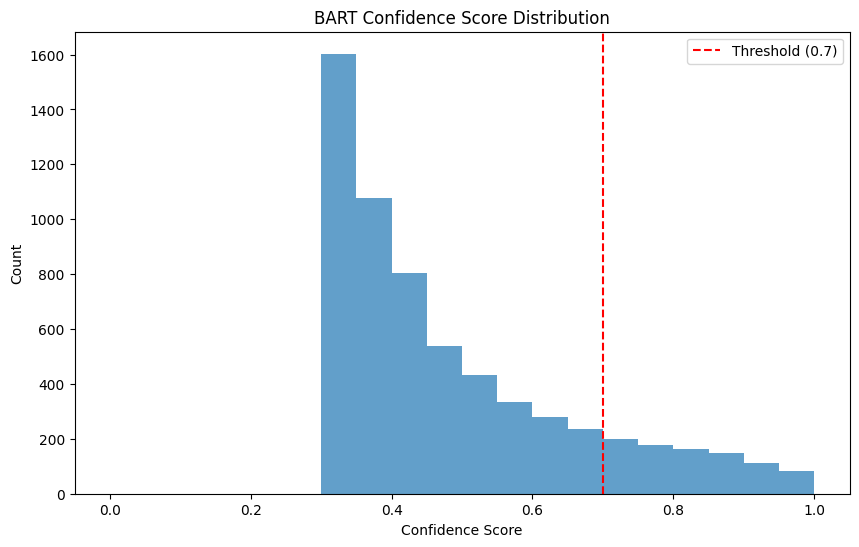

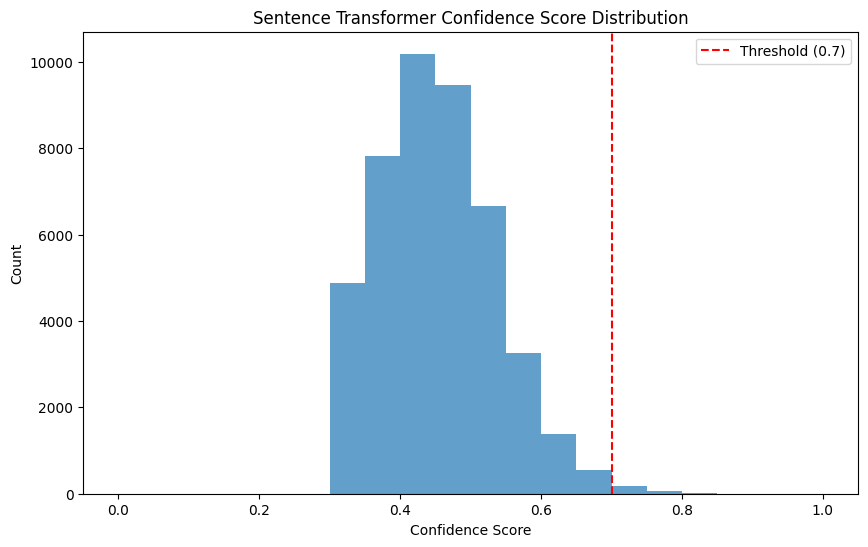

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_score_distribution(predictions, model_name):
    all_scores = [score for sublist in predictions for (_, score) in sublist]

    plt.figure(figsize=(10, 6))
    plt.hist(all_scores, bins=20, range=(0, 1), alpha=0.7)
    plt.axvline(x=0.7, color='r', linestyle='--', label='Threshold (0.7)')
    plt.title(f'{model_name} Confidence Score Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

plot_score_distribution(df['bart_predictions'], 'BART')
plot_score_distribution(df['st_predictions'], 'Sentence Transformer')

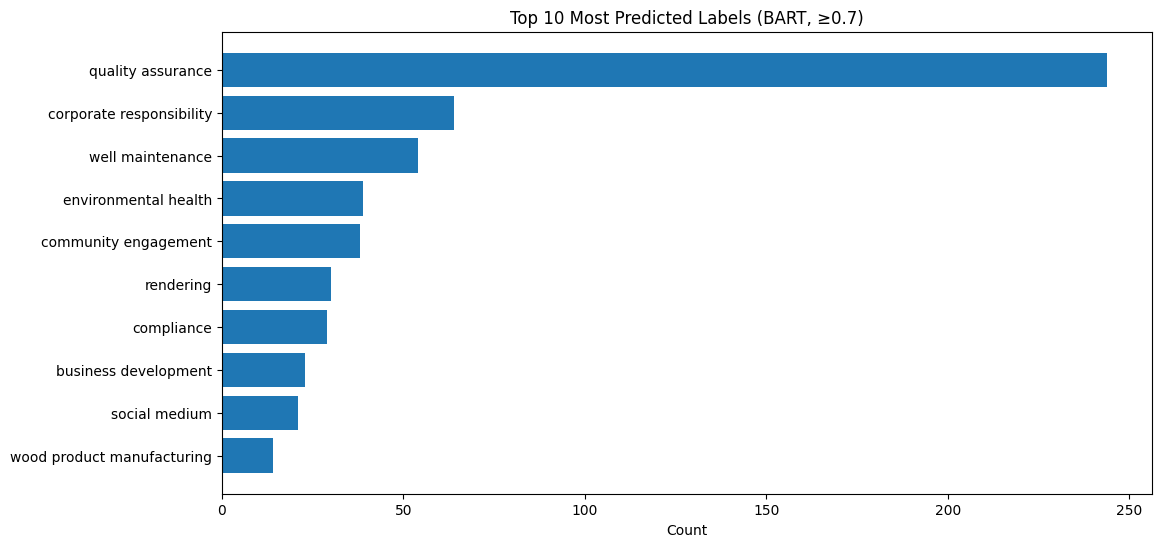

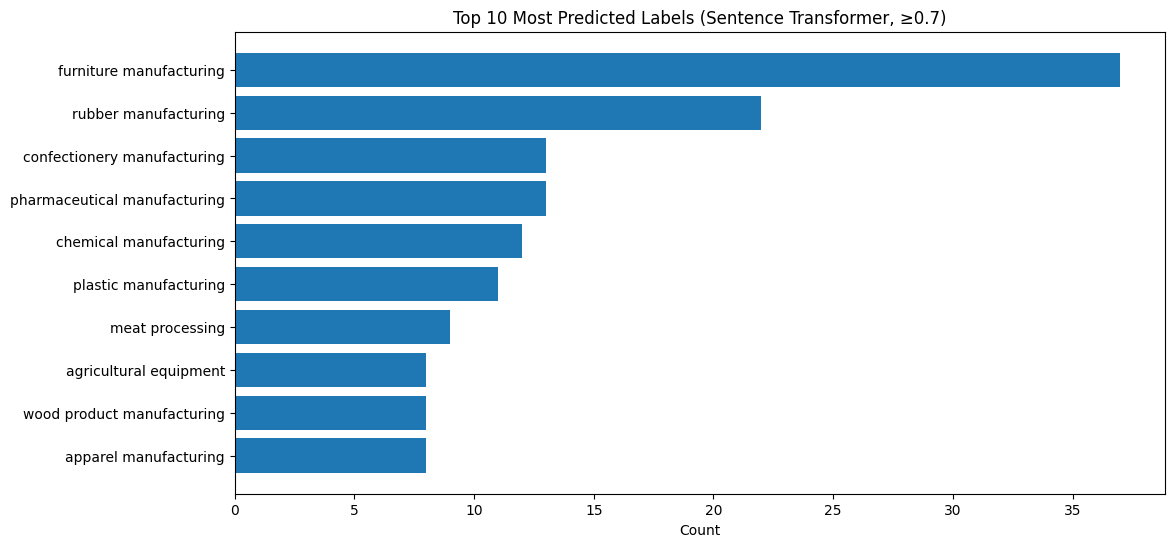

In [ ]:
from collections import Counter

def plot_top_labels(predictions, model_name, top_n=10):
    # Get all labels meeting threshold
    all_labels = [label for sublist in predictions
                 for (label, score) in sublist if score >= 0.7]

    label_counts = Counter(all_labels).most_common(top_n)
    labels, counts = zip(*label_counts)

    plt.figure(figsize=(12, 6))
    plt.barh(labels, counts)
    plt.title(f'Top {top_n} Most Predicted Labels ({model_name}, ≥0.7)')
    plt.xlabel('Count')
    plt.gca().invert_yaxis()
    plt.show()

plot_top_labels(df['bart_predictions'], 'BART')
plot_top_labels(df['st_predictions'], 'Sentence Transformer')

##SetFit

In [ ]:
!pip install setfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#deepseek full code

In [ ]:
import time
from datetime import timedelta
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import joblib
import os



# 1. Data Preparation
def prepare_labels(row):
    """Filter BART predictions to max 3 labels with confidence > 0.6"""
    try:
        if isinstance(row['bart_predictions'], str):
            predictions = ast.literal_eval(row['bart_predictions'])
        else:
            predictions = row['bart_predictions']

        if not predictions:
            return []

        predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
        filtered = [(label, score) for label, score in predictions if score > 0.6][:3]
        return [label for label, _ in filtered]
    except:
        return []


def create_combined_text(row):
    """Combine all company information into a single text"""
    tags = row['business_tags'] if isinstance(row['business_tags'], list) else []
    return f"""
    Description: {row['description']}
    Sector: {row['sector']}
    Category: {row['category']}
    Niche: {row['niche']}
    Tags: {', '.join(map(str, tags)) if tags else ''}
    """.strip()

# Apply transformations
df['labels'] = df.apply(prepare_labels, axis=1)
df['combined_text'] = df.apply(create_combined_text, axis=1)

# 2. Prepare Dataset
all_labels = list(set([label for sublist in df['labels'] for label in sublist if sublist]))
mlb = MultiLabelBinarizer(classes=all_labels)
mlb.fit(all_labels)

# Create final dataset with only needed columns
dataset_cols = ['combined_text', 'labels', 'business_tags']
dataset_df = df[dataset_cols].copy()

# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(dataset_df)

# Split into labeled/unlabeled
labeled_indices = [i for i, labels in enumerate(dataset['labels']) if len(labels) > 0]
unlabeled_indices = [i for i, labels in enumerate(dataset['labels']) if len(labels) == 0]

train_dataset = dataset.select(labeled_indices) if labeled_indices else None
unlabeled_dataset = dataset.select(unlabeled_indices) if unlabeled_indices else None

# Verify splits
print(f"\nDataset split:")
print(f"- Total samples: {len(dataset)}")
print(f"- Labeled samples: {len(train_dataset) if train_dataset else 0}")
print(f"- Unlabeled samples: {len(unlabeled_dataset) if unlabeled_dataset else 0}")



Dataset split:
- Total samples: 9491
- Labeled samples: 933
- Unlabeled samples: 8558


In [ ]:

# 3. Model Configuration
model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2",
    use_differentiable_head=True,
    multi_target_strategy="one-vs-rest"
)

# 4. Training Configuration
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    column_mapping={
        "combined_text": "text",
        "labels": "label"
    },
    batch_size=16,
    num_iterations=10,  # Number of contrastive learning pairs
    num_epochs=10,      # Number of epochs for classifier training
    learning_rate=2e-5,
    weight_decay=0.01
)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


TypeError: SetFitTrainer.__init__() got an unexpected keyword argument 'unlabeled_dataset'

In [ ]:
# Start timer
start_time = time.time()

# 5. Train the model
print("Starting training...")
trainer.train()
training_time = timedelta(seconds=time.time()-start_time)
print(f"\nTraining completed in {training_time}")

# 6. Save the model
model_dir = "company_classifier_setfit"
os.makedirs(model_dir, exist_ok=True)

# Save model weights
trainer.model.save_pretrained(model_dir)

# Save label encoder
joblib.dump(mlb, f"{model_dir}/label_encoder.pkl")

# Save training metadata
metadata = {
    "training_time": str(training_time),
    "num_samples": len(df),
    "num_labeled_samples": len(labeled_df),
    "num_unlabeled_samples": len(unlabeled_df),
    "labels": all_labels,
    "model_name": "paraphrase-mpnet-base-v2"
}

with open(f"{model_dir}/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\nModel saved to {model_dir}")

# 7. Prediction Function
def predict_labels(text, model_dir="company_classifier_setfit"):
    """Predict labels for new text with constraints"""
    # Load model
    model = SetFitModel.from_pretrained(model_dir)
    mlb = joblib.load(f"{model_dir}/label_encoder.pkl")

    # Get probabilities
    probs = model.predict_proba([text])[0]

    # Apply constraints (max 3 labels, confidence > 0.6)
    top_idx = np.argpartition(probs, -3)[-3:]  # Get top 3 indices
    preds = [(mlb.classes_[i], probs[i]) for i in top_idx if probs[i] > 0.6]

    # Sort by confidence
    return sorted(preds, key=lambda x: x[1], reverse=True)

# Example usage
sample_text = df.iloc[0]['combined_text']
print("\nSample prediction:")
print(predict_labels(sample_text))

#try do do this

In [ ]:
import time
from datetime import timedelta
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Data Preparation with Strict Label Filtering
def prepare_labels(row):
    """Filter BART predictions to max 3 labels with confidence > 0.6"""
    predictions = sorted(row['bart_predictions'], key=lambda x: x[1], reverse=True)
    filtered = [(label, score) for label, score in predictions if score > 0.6][:3]
    return [label for label, _ in filtered]

# Create combined text feature incorporating all available information
def create_combined_text(row):
    return f"""
    Company Description: {row['description']}
    Sector: {row['sector']}
    Category: {row['category']}
    Niche: {row['niche']}
    Business Tags: {', '.join(eval(row['business_tags']))}
    """.strip()

# Apply transformations
df['labels'] = df.apply(prepare_labels, axis=1)
df['combined_text'] = df.apply(create_combined_text, axis=1)

# 2. Initialize SetFit with Timing
start_time = time.time()

# Get all unique labels from BART predictions
all_labels = list(set([label for sublist in df['labels'] for label in sublist]))
mlb = MultiLabelBinarizer(classes=all_labels)
y_weak = mlb.fit_transform(df['labels'])

dataset = Dataset.from_pandas(df[['combined_text', 'labels']])

# 3. Model Configuration
model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2",
    use_differentiable_head=True,
    multi_target_strategy="one-vs-rest",
    #head_params={"max_labels": 3}  # Hard limit output
)

trainer = SetFitTrainer(
    model=model,
    train_dataset=dataset,
    eval_dataset=None,  # We'll use cross-validation
    column_mapping={
        "combined_text": "text",
        "labels": "label"
    },
    batch_size=16,
    num_iterations=20,
    num_epochs=50,
    learning_rate=2e-5,
    #weight_decay=0.01,
    metric="f1",
    early_stopping_patience=3,
    early_stopping_threshold=0.01
)


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


TypeError: SetFitTrainer.__init__() got an unexpected keyword argument 'early_stopping_patience'

In [ ]:
#4. Training with Cross-Validation (since we have no validation set)
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

kf = KFold(n_splits=3)
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"\n=== Training Fold {fold + 1}/3 ===")

    fold_train = dataset.select(train_idx)
    fold_val = dataset.select(val_idx)

    trainer.train_dataset = fold_train
    trainer.eval_dataset = fold_val

    trainer.train()

    # Predict with strict 3-label limit
    val_probs = trainer.model.predict_proba(fold_val["text"])
    val_preds = np.zeros_like(val_probs)

    # Get top 3 predictions per sample with >0.6 confidence
    for i in range(len(val_probs)):
        top_idx = np.argpartition(val_probs[i], -3)[-3:]
        val_preds[i, top_idx] = (val_probs[i, top_idx] > 0.6).astype(int)

    # Convert true labels to binary
    y_true = mlb.transform(fold_val["label"])

    # Calculate micro F1
    fold_f1 = f1_score(y_true, val_preds, average='micro')
    fold_scores.append(fold_f1)
    print(f"Fold {fold + 1} F1: {fold_f1:.4f}")

# 5. Final Model Training
print("\n=== Training Final Model ===")
trainer.train_dataset = dataset
trainer.train()

# 6. Save Model and Results
training_time = timedelta(seconds=time.time()-start_time)
print(f"\nTotal training time: {training_time}")

# Save model
model_path = "company_classifier_setfit"
trainer.model.save_pretrained(model_path)

# Save label encoder
import joblib
joblib.dump(mlb, f"{model_path}/label_encoder.pkl")

# Save performance metrics
results = {
    "cv_f1_mean": np.mean(fold_scores),
    "cv_f1_std": np.std(fold_scores),
    "training_time": str(training_time),
    "labels": all_labels
}

import json
with open(f"{model_path}/training_results.json", "w") as f:
    json.dump(results, f, indent=2)


In [ ]:

# 7. Prediction Function with Constraints
def predict_company_labels(text_data, model_path="company_classifier_setfit"):
    """Predict with same constraints used in training"""
    # Load model
    model = SetFitModel.from_pretrained(model_path)
    mlb = joblib.load(f"{model_path}/label_encoder.pkl")

    # Get probabilities
    probs = model.predict_proba([text_data])[0]

    # Apply constraints
    top_idx = np.argpartition(probs, -3)[-3:]  # Get top 3
    preds = [(mlb.classes_[i], probs[i]) for i in top_idx if probs[i] > 0.6]

    # Sort by confidence
    return sorted(preds, key=lambda x: x[1], reverse=True)

# Example usage:
sample_text = df.iloc[0]['combined_text']
print("\nSample prediction:")
print(predict_company_labels(sample_text))